# BitBIRCH best practices

This is a notebook works as an example how to use data-informed parameters for the BitBirch algorithm to obtain better results.

- [BitBIRCH: efficient clustering of large molecular libraries](https://doi.org/10.1039/D5DD00030K)
- [BitBIRCH Clustering Refinement Strategies](https://doi.org/10.1021/acs.jcim.5c00627)
- [BitBIRCH-Lean (preprint)](https://www.biorxiv.org/content/10.1101/2025.10.22.684015v1)
- [BitBIRCH best practices guidelines](https://ADD_WHEN_PUBLISHED)

Please reach out to one of the following with any questions or concerns. 

- Ramon Alain Miranda Quintana: `quintana At chem.ufl.edu`
- Kenneth Lopez Perez: `klopezperez At chem.ufl.edu`
- Ignacio Pickering: `ipickering At chem.ufl.edu`
- Krisztina Zsigmond: `kzsigmond At ufl.edu`
- Miroslav Lzicar: `miroslav.lzicar At deepmedchem.com`

## Set Up

First lets install the BitBirch-Lean package (if you have not already done so). To do
this, run the following commands in your terminal:

```
git clone https://github.com/mqcomplab/bblean.git
cd bblean
pip install -v .
```

Lets import the `bblean` package and some bblean modules, which we will use throughout
this example.

In [1]:
import bblean
import bblean.plotting as plotting
import bblean.analysis as analysis
import bblean.similarity as iSIM
import numpy as np
import matplotlib.pyplot as plt
import os

# Functions to reproduce the figures in the best practices guidelines paper
from best_practices_plots import plot_cluster_refinement, clusters_pop_plot, sampled_MSC, plot_threshold_scan
from best_practices_functions import threshold_scan, recluster_iteration_metrics

/blue/rmirandaquintana/klopezperez/bblean/bblean/similarity.py:100: UserWarning: C++ optimized similarity calculations not available, falling back to python implementation
  warnings.warn(


Let's download some smiles for this example

In [9]:
os.system("wget -q https://zenodo.org/records/17796465/files/scubidoo.smi")

0

Now let's take some SMILES strings and compute molecular fingerprints for the scubidoo (https://scubidoo.pharmazie.uni-marburg.de/) diversity library:

In [5]:
smiles = bblean.load_smiles("scubidoo.smi")

# By default the fps created are of the "ecfp4" kind. Here we use "rdkit"
fps = bblean.fps_from_smiles(smiles, pack=True, n_features=2048, kind="ecfp4")
print(f"Shape: {fps.shape}, DType: {fps.dtype}")

Shape: (999794, 256), DType: uint8


The most efficient way to store and manipulate fingerprints is using *packed*
fingerprint arrays. Packed arrays save the features in a compressed representation. To
convert between packed and unpacked fingerprints you can use
`bblean.pack_fingerprints(fps)` and `bblean.unpack_fingerprints(fps)`.

In [6]:
fps_unpacked = bblean.unpack_fingerprints(fps)
print(f"Shape unpacked: {fps_unpacked.shape}, DType unpacked: {fps_unpacked.dtype}")

fps = bblean.pack_fingerprints(fps_unpacked)
print(f"Shape re-packed: {fps.shape}, DType re-packed: {fps.dtype}")

Shape unpacked: (999794, 2048), DType unpacked: uint8
Shape re-packed: (999794, 256), DType re-packed: uint8


## Clustering fingerprints

First to define an optimal threshold we will take a look into the average similarity of
the fingerprints we want to cluster. For this we will use the iSIM formalism which can
calculate the average similarity with linear complexity.

In [7]:
isim = iSIM.jt_isim_unpacked(fps_unpacked)
print(f"Average similarity: {isim:.4f}")

Average similarity: 0.1177


Now, we will estimate the standard deviation of the similarities using a stratified
sample from our data set.

In [8]:
isim_sigma = iSIM.estimate_jt_std(fps, n_samples=50)
print(f"Estimated std of similarity: {isim_sigma:.4f}")

Estimated std of similarity: 0.0387


We can do now a threshold scan, as in the manuscript, this can take a while because it does the clustering several times. We have already identified that for most databases 3.5 or 4 isim sigmas over the global isim gives good clustering results.

In [ ]:
#threshold_df = threshold_scan(fps=fps,
#                              max_sigmas=6,
#                              branching_factor=1024)

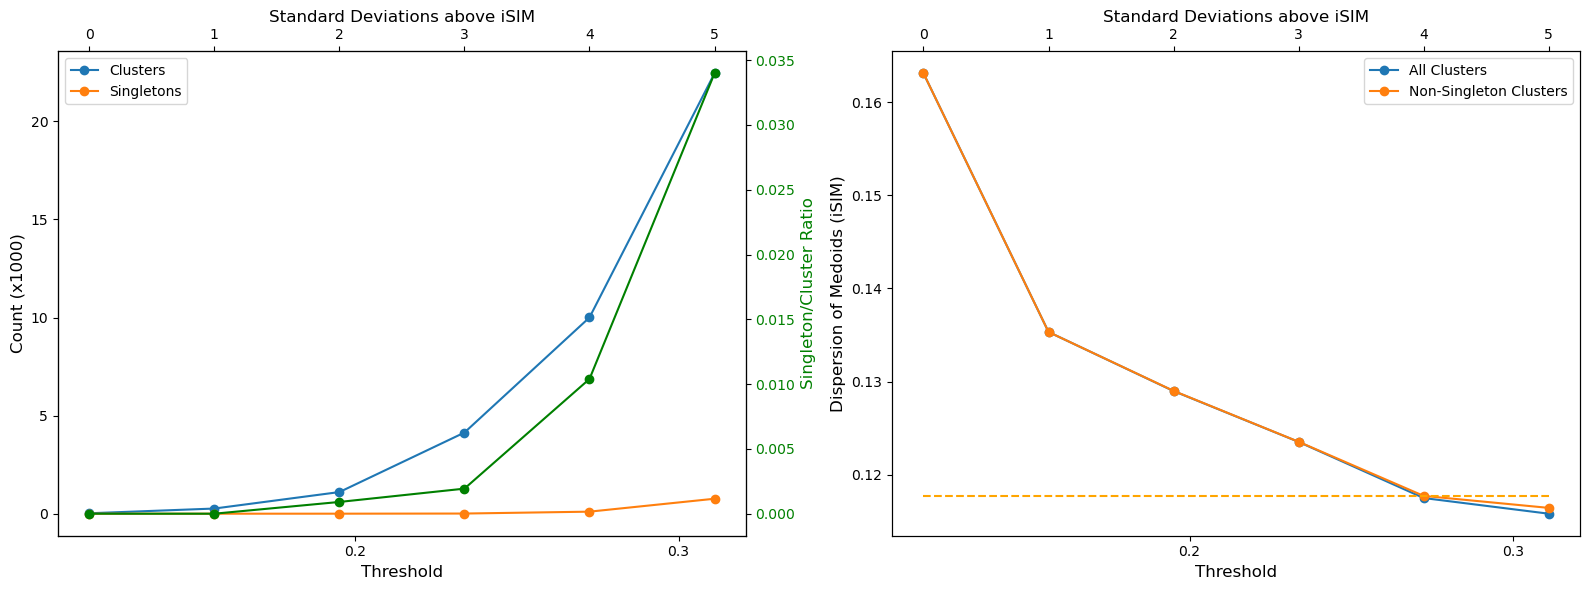

In [ ]:
#plot_threshold_scan(threshold_df, 
#                    fps,
#                    count_scale=1e3)

Now, we will do the initial clustering. 

We recommend using a threshold of 3.5 or 4 isim_sigmas over isim.

For the branching factor we recommend using a large number, as large as the time you have to compute. We will use 1024.

In [10]:
# Initialize the BitBirch tree. In general, diameter is the best merge criterion for
optimal_threshold = isim + 3.5 * isim_sigma
bb_tree = bblean.BitBirch(branching_factor = 1024, 
                          threshold=optimal_threshold, 
                          merge_criterion="diameter")

# Cluster the packed fingerprints (By default all bblean functions take packed
# fingerprints)
bb_tree.fit(fps)

BitBirch(threshold=0.25310464310837333, branching_factor=1024, merge_criterion='diameter')

Lets analyze the results to check the number of singletons

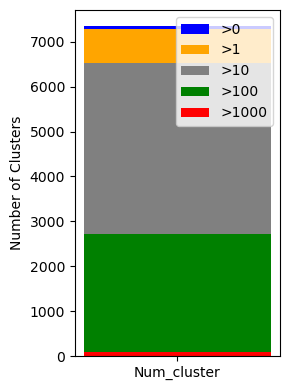

In [11]:
clusters = bb_tree.get_cluster_mol_ids()
clusters_pop_plot(clusters)

We can take a look at some of the structures to see if there they fit they make sense in terms of chemical structure.

Sample of molecules in the cluster 0, population 5646:


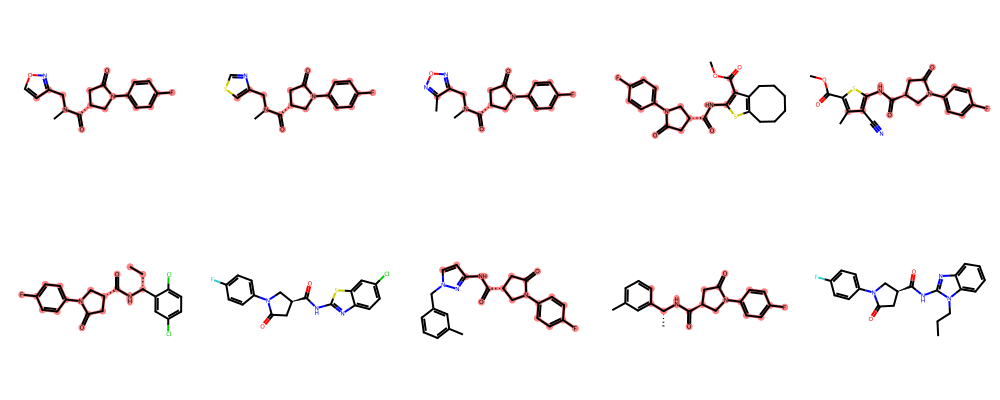

MCS:


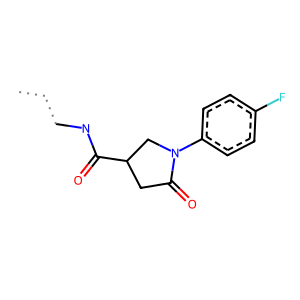

In [12]:
to_visualize = 0  # Change this to visualize other clusters
img1, img2 = sampled_MSC(cluster=clusters[to_visualize], smiles = smiles, n_samples=10)
print(f"Sample of molecules in the cluster {to_visualize}, population {len(clusters[to_visualize])}:")
display(img1)
print(f"MCS:")
display(img2)

As we see, the number of singletons is not high. If for some application someone needed to further reduce the number of small clusters, we introduce the recluster_inplace method. Usually 5 iterations is enough to get rid of spurious singletons that are not really outliers.
You may want to change the `extra_threshold` parameter, and the number of iterations deoending on your needs.

We can notice that in this case the change is not as big as with ChEMBL, meaning that the initial pick of threshold and branching factor might be enough and no reclustering would be needed.

In [9]:
reclustering_metrics = recluster_iteration_metrics(fps=fps,
                                threshold=optimal_threshold,
                                branching_factor=1024,
                                iterations=5,
                                extra= 1) # In this function extra is expressed in number of std deviations

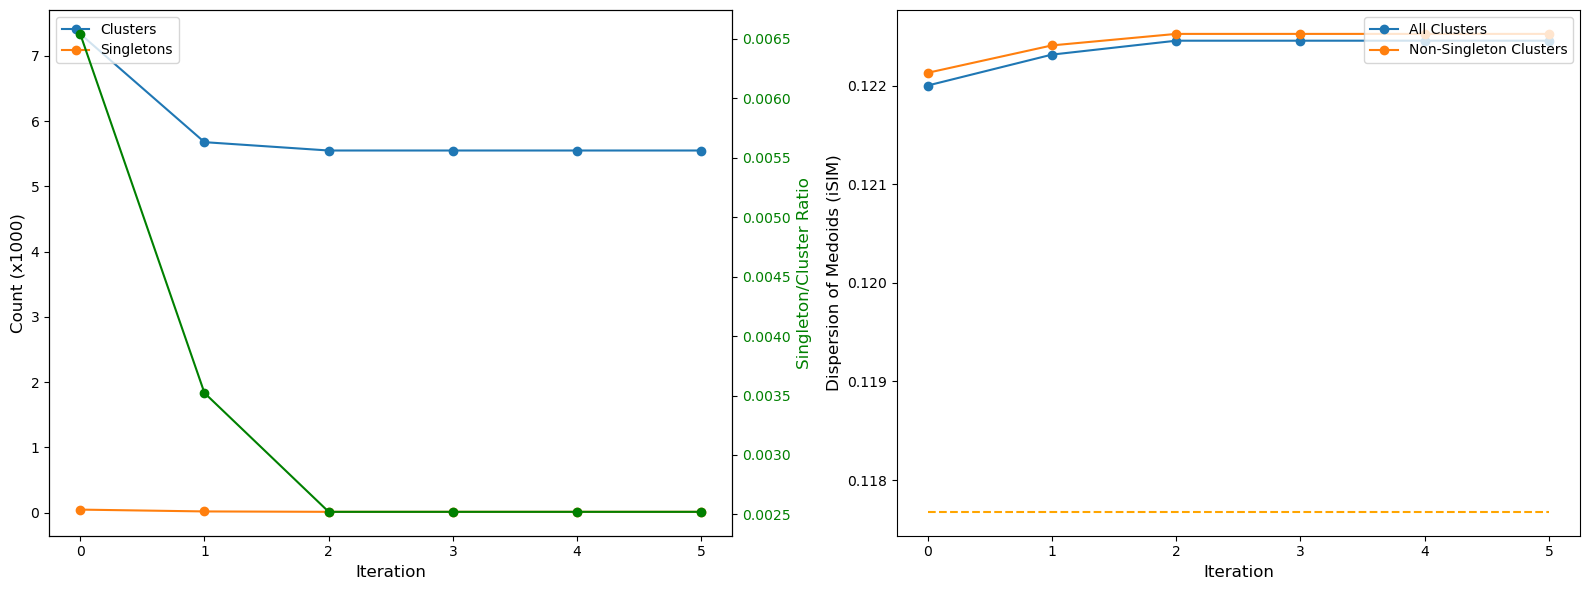

(<Figure size 1600x600 with 3 Axes>,
 array([<Axes: xlabel='Iteration', ylabel='Count (x1000)'>,
        <Axes: xlabel='Iteration', ylabel='Dispersion of Medoids (iSIM)'>],
       dtype=object))

In [10]:
plot_cluster_refinement(reclustering_metrics,
                        fps=fps,
                        count_scale=1e3)

We see that the number of singletons significantly decreased

## Further analysis and Visualization

Lets inspect some features of the generated clusters:

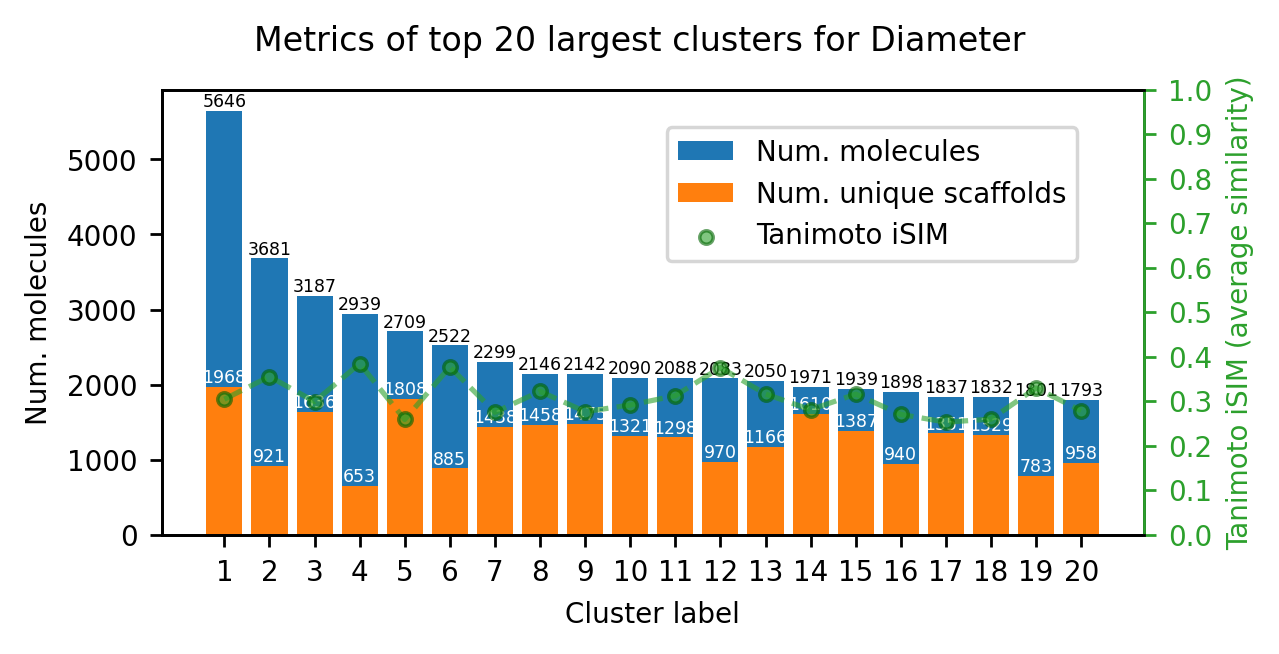

In [21]:
# First we run a cluster analysis on the resulting ids
clusters = bb_tree.get_cluster_mol_ids()
ca = analysis.cluster_analysis(clusters, fps, smiles)

# Afterwards we can use the utility functions on the bblean.plotting module
plotting.summary_plot(ca, title="Diameter")
plt.show()

In [23]:
# Total clusters
print("Number of clusters: ", len(clusters))

# Clusters with more than 10 molecules
large_clusters = [c for c in clusters if len(c) > 10]
print("Number of clusters with more than 10 molecules: ", len(large_clusters))

Number of clusters:  7338
Number of clusters with more than 10 molecules:  6531


We can also visualize the clusters using a t-SNE plot with `plotting.tsne_plot`:

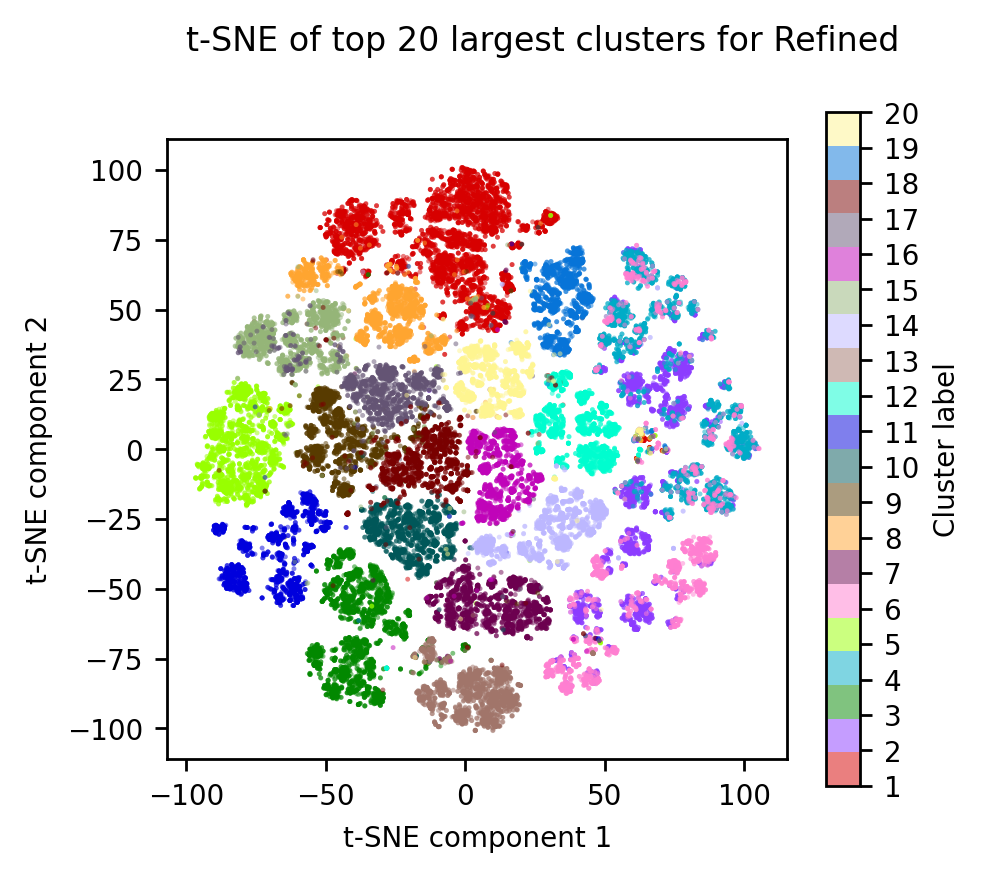

In [24]:
plotting.tsne_plot(ca, title="Refined")
plt.show()

## Final cluster assignments

Once we are happy with the clustering results, we can save the final cluster
assignments. to a `*.csv` file.

In [8]:
bb_tree.dump_assignments("smiles-assignments.csv", smiles)